In [1]:
import nibabel as nib
import os, glob
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.nn import MSELoss
import monai
import torch.nn.functional as F
import monai.networks.nets as nets
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset, PatchDataset
from monai.inferers import SliceInferer
from monai.utils import set_determinism, first
from monai.transforms import(
    Compose,
    Lambdad,
    LoadImaged,
    EnsureChannelFirstd,
    MapTransform,
    SqueezeDimd, 
    RandSpatialCropSamplesd, 
    ScaleIntensityRangePercentilesd, 
    Resized,
    CropForegroundd, 
    CenterSpatialCropd, 
    RandZoomd
)
from monai.losses import DiceCELoss
# print_config()
from datetime import date
today = str(date.today()).replace('-','').replace(' ', '')
gpu_device = torch.device(f'cuda:{0}')

/home/kharroubi/anaconda3/envs/project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Options():
    def __init__(self):
        # I/O
        self.where_is_ProstaTS = '/home/kharroubi/Dataset/Multireader_NIFTI_crop'
        self.Masks_uncertainty = '/home/kharroubi/Dataset/Masks_Uncertainty_Maps'
        self.RESULTS_DIR = '/home/kharroubi/2Decoders'
        self.EXPERIMENT_PREFIX='SEGTEST'
        self.weights_dir=os.path.join('/home/kharroubi/EXPERIMENTS/SEG', self.EXPERIMENT_PREFIX)
        
        # model parameters
        self.in_channels = 4  # Adjust according to your input image channel dimensions
        self.out_channels = 1  # Adjust according to your output image channel dimensions
        self.num_res_units_G = 9
        self.ROI_SIZE=(128,128,32)
        # training parameters
        self.num_epochs=30
        self.N_train = 60  # number of training samples
        self.learning_rate = 2e-4
        self.lambda_DiceCE=1  
        self.lambda_multi_loss = 1  # Weight for multi-class segmentation loss 
        self.lambda_conf= 1
        self.lambda_CE = 1
        self.val_every=5  #  check val every ? step

opt=Options()

In [21]:
from monai.transforms import MapTransform, Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRangePercentilesd, Resized
from monai.data import CacheDataset, DataLoader
import numpy as np
from monai.data.meta_tensor import MetaTensor
import torch
# Custom transform to map specific values
class MapUncMaskValues(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.mapping = {0.0000: 0, 0.49803925: 1, 1.0000: 2}

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in d:
                mask = d[key]
                if isinstance(mask, MetaTensor):
                    # Convert MetaTensor to numpy array for processing
                    mask_array = mask.cpu().numpy() if torch.is_tensor(mask) else mask.numpy()
                    conditions = [mask_array == k for k in self.mapping.keys()]
                    choices = list(self.mapping.values())
                    mapped_array = np.select(conditions, choices, default=mask_array)
                    # Convert numpy array back to MetaTensor
                    d[key] = MetaTensor(torch.tensor(mapped_array), meta=mask.meta)
                else:
                    raise TypeError(f"Expected MetaTensor for {key}, but got {type(mask)}")
        return d

In [22]:
# Define file paths and create dictionaries for training and validation data
PIDs_ALL = [i.split('/')[-1] for i in glob.glob(os.path.join(opt.where_is_ProstaTS, 'ANON*'))]
np.random.seed(29100)
np.random.shuffle(PIDs_ALL)

PIDs_train = PIDs_ALL[:opt.N_train]
PIDs_val = PIDs_ALL[opt.N_train:65]

fnames_train = {seq: [os.path.join(opt.where_is_ProstaTS, PID, PID + f"_{seq}.nii.gz") for PID in PIDs_train] for seq in ['T2', 'B2000', 'Perf', 'ADC']}
fnames_train.update({
    'MASK_VB': [os.path.join(opt.where_is_ProstaTS, PID, 'mask_Prostate_VB.nii.gz') for PID in PIDs_train],
    'Unc_MASK': [os.path.join(opt.Masks_uncertainty, PID + '_uncertainty_map.nii.gz') for PID in PIDs_train]
})

train_dic = [{"T2": img1, "B2000": img2, "Perf": img3, "ADC": img4, "MASK_VB": img5, "Unc_MASK": img6 }
             for img1, img2, img3, img4, img5, img6 in zip(*[fnames_train[seq] for seq in ['T2', 'B2000', 'Perf', 'ADC', 'MASK_VB', 'Unc_MASK']])]

fnames_val = {seq: [os.path.join(opt.where_is_ProstaTS, PID, PID + f"_{seq}.nii.gz") for PID in PIDs_val] for seq in ['T2', 'B2000', 'Perf', 'ADC']}
fnames_val.update({
    'MASK_VB': [os.path.join(opt.where_is_ProstaTS, PID, 'mask_Prostate_VB.nii.gz') for PID in PIDs_val],
    'Unc_MASK': [os.path.join(opt.Masks_uncertainty, PID + '_uncertainty_map.nii.gz') for PID in PIDs_val]
})

val_dic = [{"T2": img1, "B2000": img2, "Perf": img3, "ADC": img4, "MASK_VB": img5, "Unc_MASK": img6 }
           for img1, img2, img3, img4, img5, img6 in zip(*[fnames_val[seq] for seq in ['T2', 'B2000', 'Perf', 'ADC', 'MASK_VB', 'Unc_MASK']])]

# Define transforms for training and validation
train_transforms = Compose([
    LoadImaged(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"], image_only=False),
    EnsureChannelFirstd(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"]),
    ScaleIntensityRangePercentilesd(keys=["T2", "B2000", "Perf", "ADC"], lower=1, upper=99, b_min=-1,b_max=1, clip=True),
    Resized(keys=["T2","B2000","Perf","ADC"], spatial_size=opt.ROI_SIZE, mode="trilinear"),
    Resized(keys=["MASK_VB"], spatial_size=opt.ROI_SIZE, mode="nearest"),
    Resized(keys=["Unc_MASK"], spatial_size=opt.ROI_SIZE, mode="nearest"),
    MapUncMaskValues(keys=["Unc_MASK"])
    
])

val_transforms = Compose([
    LoadImaged(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"], image_only=False),
    EnsureChannelFirstd(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"]),
    ScaleIntensityRangePercentilesd(keys=["T2", "B2000", "Perf", "ADC"], lower=1, upper=99, b_min=-1,b_max=1, clip=True),
    Resized(keys=["T2","B2000","Perf","ADC"], spatial_size=opt.ROI_SIZE, mode="trilinear"),
    Resized(keys=["MASK_VB"], spatial_size=opt.ROI_SIZE, mode="nearest"),
    Resized(keys=["Unc_MASK"], spatial_size=opt.ROI_SIZE, mode="nearest"),
    MapUncMaskValues(keys=["Unc_MASK"])
])

BATCH_SIZE = 1
NUM_WORKERS = 1

train_ds_fullsize = CacheDataset(train_dic, train_transforms, num_workers=NUM_WORKERS)
train_loader_fullsize = DataLoader(train_ds_fullsize, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_ds_fullsize = CacheDataset(val_dic, val_transforms, num_workers=NUM_WORKERS)
val_loader_fullsize = DataLoader(val_ds_fullsize, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


Loading dataset:   0%|          | 0/60 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Unique values in Unc_MASK: metatensor([0., 1., 2.], dtype=torch.float64)


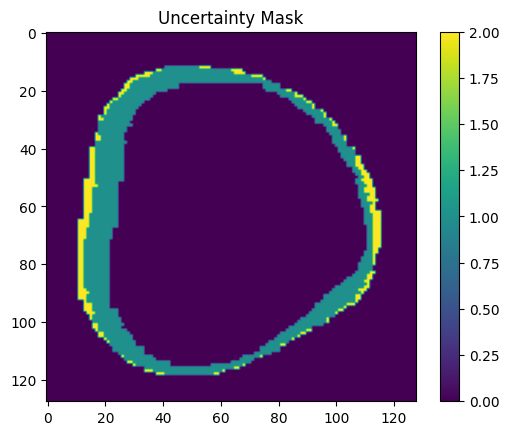

In [32]:
# Assuming `train_dataset` is your dataset with `train_transforms` applied
sample = val_ds_fullsize[0]  # Load a sample from the dataset

unc_mask = sample["Unc_MASK"]

# Check unique values to verify categorical labels are preserved
unique_values = torch.unique(unc_mask)
print("Unique values in Unc_MASK:", unique_values)

# Visualize a slice of the Unc_MASK to visually confirm categories
plt.imshow(unc_mask[0, :, :, 16].cpu(), cmap='viridis')  # Adjust slice index as needed
plt.colorbar()
plt.title("Uncertainty Mask")
plt.show()
#Unc_MASK having values [0.0000, 0.4980, 1.0000], and these represent the uncertainty levels (0, 1, 2) respectively

#0.0000 -> Class 0 (Low uncertainty)
#0.4980 -> Class 1 (Medium uncertainty)
#1.0000 -> Class 2 (High uncertainty)

In [24]:
# Assuming `train_loader` is your DataLoader and it's already defined

for real in train_ds_fullsize:
    real_B_unc = real["Unc_MASK"].to(gpu_device)
    print(f"Shape of real_B_unc: {real_B_unc.shape}")
    print(f"Unique values in real_B_unc: {torch.unique(real_B_unc)}")
    break  # Only inspect the first batch


Shape of real_B_unc: torch.Size([1, 128, 128, 32])
Unique values in real_B_unc: tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64)


In [6]:
import torch

# Check if CUDA (GPU) is available
cuda_available = torch.cuda.is_available()

# Get the number of available GPUs
num_gpus = torch.cuda.device_count()

# Print CUDA availability and number of GPUs
if cuda_available:
    print(f"CUDA is available with {num_gpus} GPU(s)!")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available with 1 GPU(s)!


Epoch [1/40]: 100%|██████████| 60/60 [00:15<00:00,  3.86it/s, loss=1.6982]


Epoch 1, Validation Loss: 1.5606


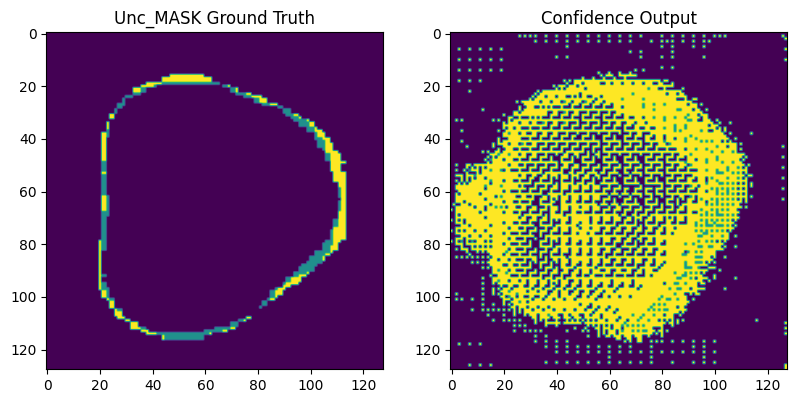

Epoch [5/40]: 100%|██████████| 60/60 [00:15<00:00,  3.87it/s, loss=1.0680]


Epoch 5, Validation Loss: 1.0587


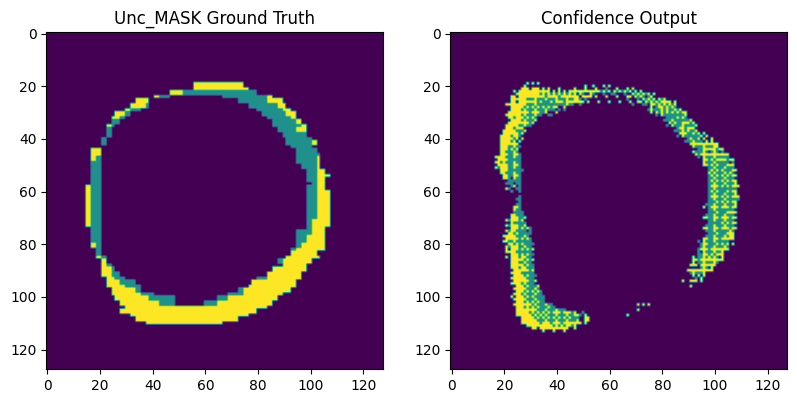

Epoch [10/40]: 100%|██████████| 60/60 [00:15<00:00,  3.87it/s, loss=0.8482]


Epoch 10, Validation Loss: 0.9065


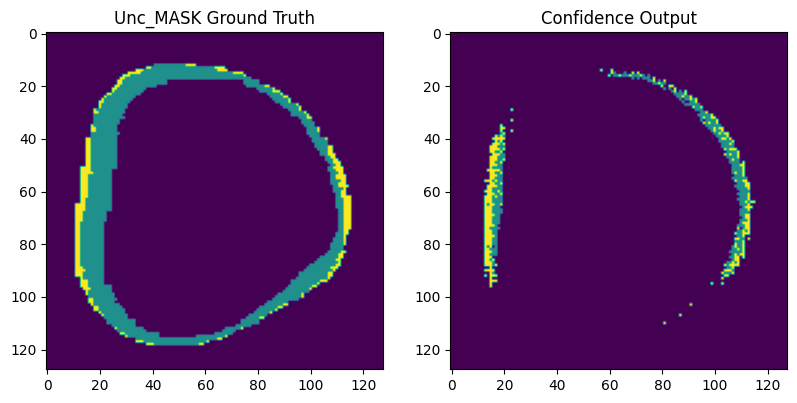

Epoch [15/40]: 100%|██████████| 60/60 [00:15<00:00,  3.82it/s, loss=0.7657]


Epoch 15, Validation Loss: 0.8689


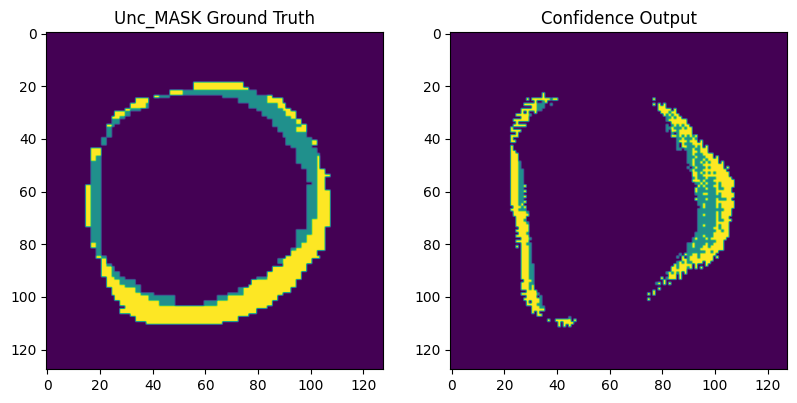

Epoch [20/40]: 100%|██████████| 60/60 [00:15<00:00,  3.88it/s, loss=0.6982]


Epoch 20, Validation Loss: 0.8639


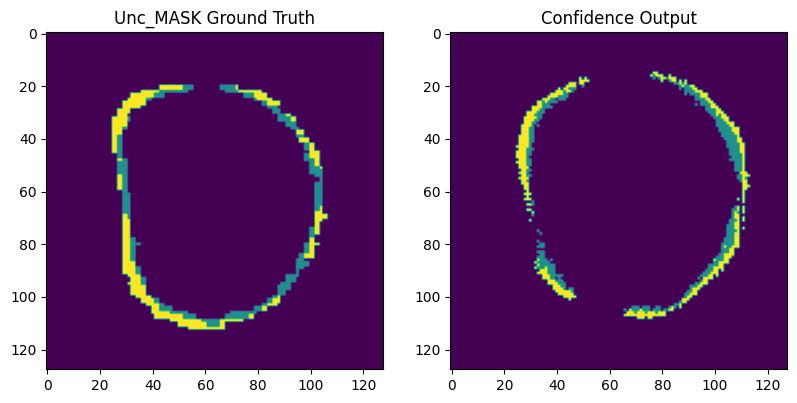

Epoch [25/40]: 100%|██████████| 60/60 [00:15<00:00,  3.85it/s, loss=0.6484]


Epoch 25, Validation Loss: 0.8524


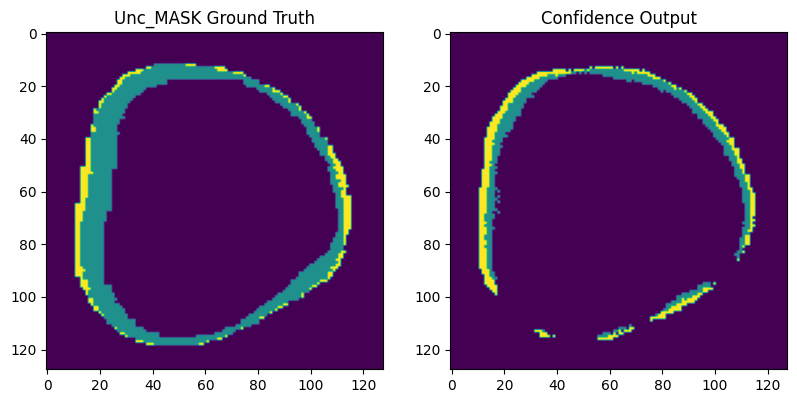

Epoch [30/40]: 100%|██████████| 60/60 [00:16<00:00,  3.66it/s, loss=0.5805]


Epoch 30, Validation Loss: 0.8695


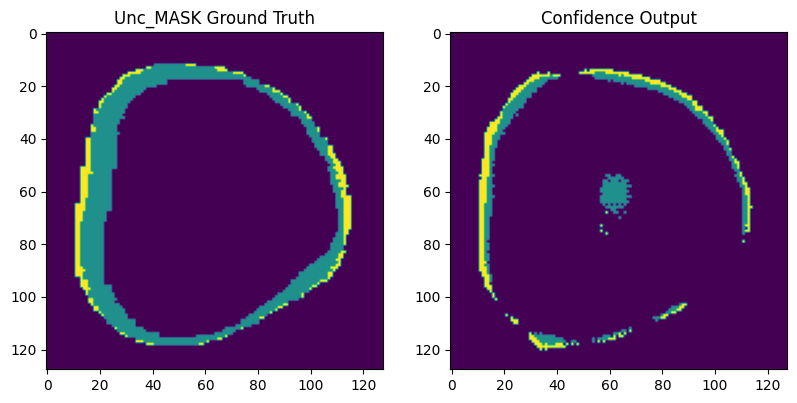

Epoch [35/40]: 100%|██████████| 60/60 [00:16<00:00,  3.67it/s, loss=0.5269]


Epoch 35, Validation Loss: 0.9013


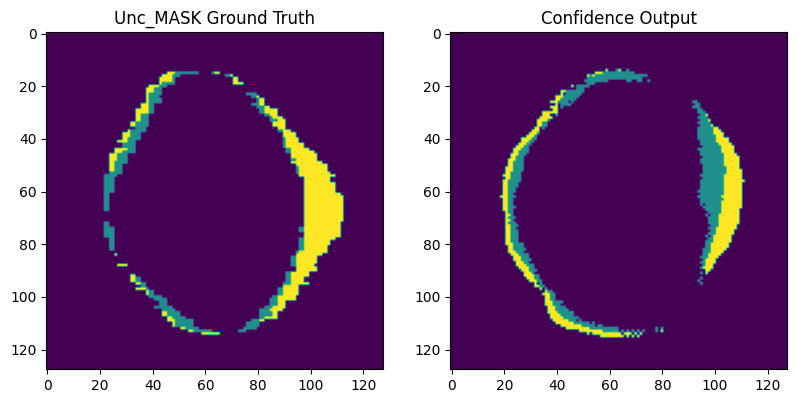

Epoch [40/40]: 100%|██████████| 60/60 [00:16<00:00,  3.64it/s, loss=0.4450]


Epoch 40, Validation Loss: 0.9573


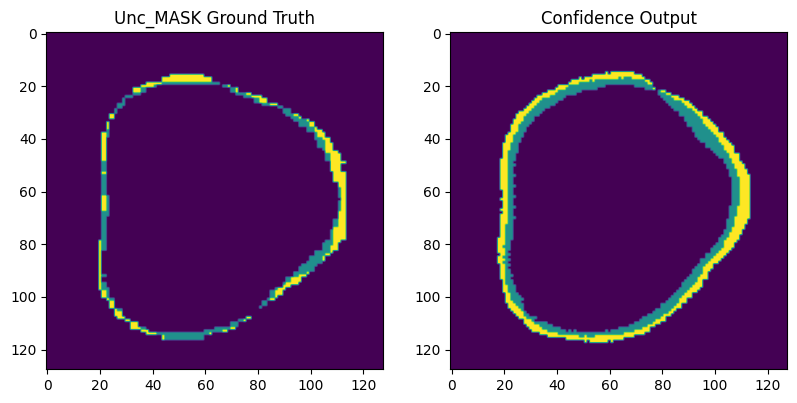

In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import monai
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRangePercentilesd, Resized
from monai.data import DataLoader, CacheDataset

# Define a simplified confidence model with architecture similar to confidence_unet
class SimpleConfidenceModel(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, num_res_units=3):
        super(SimpleConfidenceModel, self).__init__()
        self.confidence_unet = UNet(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(64,128,128,256), #(32, 64, 64, 128),  # Example channel configuration
            strides=(2, 2, 2),
            num_res_units=num_res_units
        ).to(gpu_device)

    def forward(self, x):
        return self.confidence_unet(x)

# Instantiate SimpleConfidenceModel and move to GPU if available
model_confidence = SimpleConfidenceModel(
    in_channels=4,
    out_channels=3,  # Adjust as per your task requirements, e.g., number of classes
    num_res_units=3
).to(gpu_device)


# Define optimizer and loss function
learning_rate = 1e-4
optimizer_confidence = torch.optim.Adam(model_confidence.parameters(), lr=learning_rate)
criterion_confidence = DiceCELoss(to_onehot_y=True, softmax=True)


# Training loop
num_epochs = 40
for epoch in range(1, num_epochs + 1):
    model_confidence.train()
    epoch_loss = 0.0
    loop = tqdm(train_loader_fullsize)
    loop.set_description(f"Epoch [{epoch}/{num_epochs}]")

    for batch_idx, real in enumerate(loop):
        real_A = torch.cat([real[key].to(gpu_device) for key in ["T2", "B2000", "Perf", "ADC"]], dim=1)
        real_B_unc = real["Unc_MASK"].to(gpu_device)
        
        
        optimizer_confidence.zero_grad()
        conf_out = model_confidence(real_A)

        # Assuming real_B_unc is the ground truth for confidence prediction
        loss = criterion_confidence(conf_out, real_B_unc)
        
        loss.backward()
        optimizer_confidence.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=f"{epoch_loss / (batch_idx + 1):.4f}")

    # Validation
    if epoch % opt.val_every == 0 or epoch == 1:
        model_confidence.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, real_val in enumerate(val_loader_fullsize):
                real_A_val = torch.cat([real_val[key].to(gpu_device) for key in ["T2", "B2000", "Perf", "ADC"]], dim=1)
                real_B_unc_val = real_val["Unc_MASK"].to(gpu_device)

                conf_out_val = model_confidence(real_A_val)
                
                val_loss += criterion_confidence(conf_out_val, real_B_unc_val).item()

            avg_val_loss = val_loss / len(val_loader_fullsize)
            print(f"Epoch {epoch}, Validation Loss: {avg_val_loss:.4f}")
             # Assuming conf_out_val is logits or probabilities, convert it to predictions
            pred_unc_np = torch.argmax(conf_out_val, dim=1).cpu().numpy()

            plt.figure(figsize=(20, 10))
            # Plot T2, B2000, Perf, ADC images (omitted for brevity)

            # Plot UNC_MASK ground truth
            plt.subplot(2, 4, 5)
            plt.imshow(real_B_unc_val[0, 0, :, :, int(opt.ROI_SIZE[2] // 2)].cpu().detach().numpy().squeeze(), vmin=0, vmax=2, cmap='viridis')
            plt.title('Unc_MASK Ground Truth')

            # Plot Confidence output
            plt.subplot(2, 4, 6)
            plt.imshow(pred_unc_np[0, :, :, int(opt.ROI_SIZE[2] // 2)], vmin=0, vmax=2, cmap='viridis')
            plt.title('Confidence Output')

            plt.show()